Let's create a Multi-Layer Perceptron language model for subreddit names.


This loosely follows part 2 of Andrej Karpathy's excellent [makemore](https://github.com/karpathy/makemore); go and check that out first.
However he used a list of US names, where we're going to use subreddit names.
We'll follow the model in [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) of building a simple 2 layer MLP on a fixed length window, but instead of using words we will use characters.

::: {.callout-note}
This is a Jupyter notebook you can [download the notebook](https://github.com/EdwardJRoss/skeptric/blob/master/makemore-subreddits-part-2-mlp/index.ipynb) or [view it on Kaggle](https://www.kaggle.com/code/edwardjross/makemore-subreddits-part-2-mlp).
:::

# Loading the Data

This is largely similar to [Part 1](https://skeptric.com/makemore-subreddits-part-1-bigram-model/) where we get the most common subreddit names from  [All Subreddits and Relations Between Them](https://www.kaggle.com/datasets/thedevastator/all-subreddits-and-relations-between-them).

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
import csv
from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm

Filter to subreddits that:

* Have at least 1000 subscribers
* Are not archived
* Are safe for work
* And are not quarintined

In [10]:
data_path = Path('/kaggle/input/all-subreddits-and-relations-between-them')
min_subscribers = 1_000

with open(data_path / 'subreddits.csv', 'r') as f:
    names = [d['name'] for d in csv.DictReader(f) 
             if int(d['subscribers'] or 0) >= min_subscribers
             and d['description']
             and d['type'] != 'archived'
             and d['nsfw'] == 'f'
             and d['quarantined'] == 'f']
    
len(names)
random.seed(42)
random.shuffle(names)

Because we are using a more powerful model we will make a train/val/test split at 80%/10%/10% to identify overfitting.

In [11]:
N = len(names)

names_train = names[:int(0.8*N)]
names_val = names[int(0.8*N):int(0.9*N)]
names_test = names[int(0.9*N):]


len(names_train), len(names_val), len(names_test)

(26876, 3359, 3360)

The names are largely human readable.

In [12]:
for name in names_train[:10]:
    print(name)

splunk
thenwa
soylent
factorio
christinaricci
blues
vegancheesemaking
goldredditsays
reformed
nagoya


# Compile the Data

Now convert the dataset into something that the model can easily work with.
First represent all the character tokens as consecutive integers.
We create a special `PAD_CHAR` with index 0 to represent tokens outside of the sequence.

In [13]:
PAD_CHAR = '.'
PAD_IDX = 0

i2s = sorted(set(''.join(names_train)))
assert PAD_CHAR not in i2s

i2s.insert(PAD_IDX, PAD_CHAR)

s2i = {s:i for i, s in enumerate(i2s)}

V = len(i2s)

print(i2s)

['.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Then we want to predict the next character given the previous `block_size` characters.

For example with 3 characters of context we want to create `x` that contains consecutive strings of 3 characters, and `y` that contains the fourth character.

In [14]:
padded_name = '...abcdef.'

for *x, y in zip(*[padded_name[i:] for i in range(4)]):
    print(x, y)

['.', '.', '.'] a
['.', '.', 'a'] b
['.', 'a', 'b'] c
['a', 'b', 'c'] d
['b', 'c', 'd'] e
['c', 'd', 'e'] f
['d', 'e', 'f'] .


We then apply this process to each of our data splits.

In [15]:
block_size = 3

def compile_dataset(names, block_size, PAD_CHAR=PAD_CHAR, s2i=s2i):
    X, y = [], []
    for name in names:
        padded_name = PAD_CHAR * block_size + name + PAD_CHAR
        padded_tokens = [s2i[c] for c in padded_name]
        for *context, target in zip(*[padded_tokens[i:] for i in range(block_size+1)]):
            X.append(context)
            y.append(target)
    return torch.tensor(X), torch.tensor(y)

# Note about vocab
X, y = compile_dataset(names_train, block_size)
X_val, y_val = compile_dataset(names_val, block_size)
X_test, y_test = compile_dataset(names_test, block_size)

X.shape, y.shape

(torch.Size([330143, 3]), torch.Size([330143]))

Then the task is to predict the next token given the context, where `.` in `X` represents before the start of a string, and in `y` represents the end of a string.

In [16]:
print(names_train[:3])
print()
for xi, yi in zip(X[:20], y[:20]):
    print([i2s[t] for t in xi], i2s[yi])

['splunk', 'thenwa', 'soylent']

['.', '.', '.'] s
['.', '.', 's'] p
['.', 's', 'p'] l
['s', 'p', 'l'] u
['p', 'l', 'u'] n
['l', 'u', 'n'] k
['u', 'n', 'k'] .
['.', '.', '.'] t
['.', '.', 't'] h
['.', 't', 'h'] e
['t', 'h', 'e'] n
['h', 'e', 'n'] w
['e', 'n', 'w'] a
['n', 'w', 'a'] .
['.', '.', '.'] s
['.', '.', 's'] o
['.', 's', 'o'] y
['s', 'o', 'y'] l
['o', 'y', 'l'] e
['y', 'l', 'e'] n


We can also look at this in terms of the underlying numeric representation.

In [17]:
torch.cat([X[:20], y[:20].unsqueeze(1)], axis=1)

tensor([[ 0,  0,  0, 30],
        [ 0,  0, 30, 27],
        [ 0, 30, 27, 23],
        [30, 27, 23, 32],
        [27, 23, 32, 25],
        [23, 32, 25, 22],
        [32, 25, 22,  0],
        [ 0,  0,  0, 31],
        [ 0,  0, 31, 19],
        [ 0, 31, 19, 16],
        [31, 19, 16, 25],
        [19, 16, 25, 34],
        [16, 25, 34, 12],
        [25, 34, 12,  0],
        [ 0,  0,  0, 30],
        [ 0,  0, 30, 26],
        [ 0, 30, 26, 36],
        [30, 26, 36, 23],
        [26, 36, 23, 16],
        [36, 23, 16, 25]])

# Multi-Layer Perceptron

We will follow the basic model of [Bengio., et al (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

* Each token is embedded by a $\left | V \right| \times m$ dimensional matrix `C`
* The consecutive tokens are then concatenated together across the block size `n` to get $x = (C(w_{t−1}),C(w_{t−2}), · · · ,C(w+{t−n+1}))$
* This is passed through two hidden layers, with an optional skip connection $y = b +W x +U \tanh(d + Hx)$

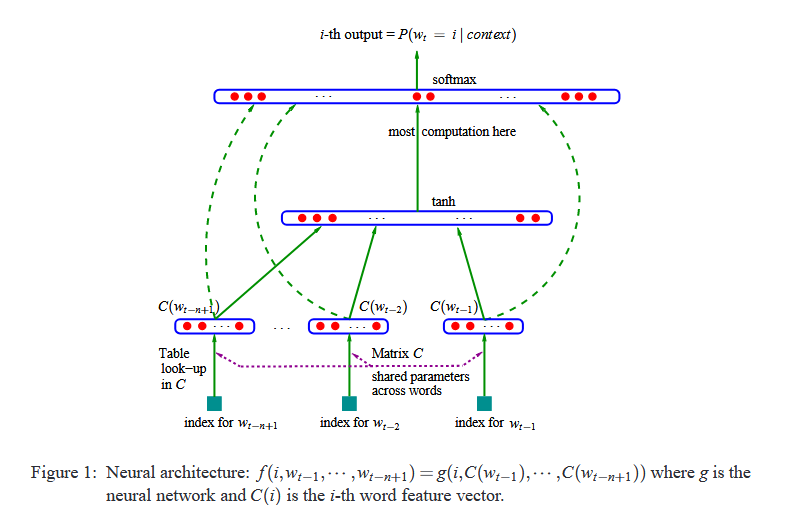

We'll ignore the skip connection for now and build the basic model

In [18]:
# Character embedding dimension
m = 2
# Hidden layer dimension
h = 100

# Word embedding layer
C = torch.randn(V, m)

# First hidden layer
H = torch.randn(block_size * m, h)
d = torch.randn(h)

# Second hidden layer
U = torch.randn(h, V)
b = torch.randn(V)

parameters = [C, H, d, U, b]

[p.numel() for p in parameters], [V*m, block_size*m*h, h, h*V, V]

([76, 600, 100, 3800, 38], [76, 600, 100, 3800, 38])

In [19]:
for p in parameters:
    p.requires_grad = True

Let's go through the model step by step with a small minibatch of size `B` (here 4)

In [20]:
batch_size = 4

idx = list(range(batch_size))
idx

[0, 1, 2, 3]

First we get the features and targets:

In [21]:
X[idx], y[idx]

(tensor([[ 0,  0,  0],
         [ 0,  0, 30],
         [ 0, 30, 27],
         [30, 27, 23]]),
 tensor([30, 27, 23, 32]))

We use the embedding matrix to get the corresponding $B \times n \times m$ token embedding matrix where here `n = block_size = 3`

In [22]:
embeddings = C[X[idx]]
embeddings.shape

torch.Size([4, 3, 2])

We want to then map it to a hidden layer, so we mix together the dimensions using an affine transformation.

Note that using view we can consider the embeddings as a rank-2 tensor of dimension $B \times (m \times n)$.
We then get output a $B \times h$ matrix where here `h=100` is the hidden size.

In [23]:
hidden_layer = embeddings.view(batch_size, block_size * m) @ H + d
hidden_layer.shape

torch.Size([4, 100])

We then pass it through the `tanh` activation function, and another affine transformation to get the logits. 

In [24]:
output_logits = torch.tanh(hidden_layer) @ U + b
output_logits.shape

torch.Size([4, 38])

Finally performing a softmax gets the probabilities.

In [25]:
output_probs = output_logits.exp()
output_probs /= output_probs.sum(axis=1, keepdim=True)

output_probs

tensor([[4.7666e-01, 1.2071e-04, 1.8991e-02, 7.3004e-08, 1.1990e-08, 5.2684e-05,
         1.3352e-05, 3.5838e-06, 3.7178e-15, 1.6968e-11, 1.4544e-09, 2.2657e-04,
         4.4790e-10, 1.7938e-09, 4.2694e-01, 1.4668e-07, 2.2485e-05, 1.0456e-09,
         2.1118e-03, 1.3098e-08, 1.9163e-06, 9.6630e-10, 2.3439e-04, 1.4318e-02,
         7.5780e-03, 6.0088e-04, 1.6348e-02, 1.6981e-05, 1.0376e-05, 2.1339e-05,
         3.0579e-02, 4.3965e-04, 4.7099e-03, 2.4874e-11, 1.2188e-10, 6.3377e-08,
         1.1395e-10, 3.1587e-14],
        [1.1188e-09, 1.2986e-04, 1.9391e-03, 7.5456e-09, 1.1886e-10, 6.7563e-13,
         5.2620e-06, 6.4061e-14, 3.2493e-09, 1.7278e-06, 3.8212e-09, 2.2627e-05,
         2.7201e-16, 3.4729e-18, 3.2816e-03, 6.6333e-11, 3.6413e-10, 9.9206e-01,
         7.0343e-11, 2.7351e-04, 1.2310e-12, 3.1674e-11, 3.2047e-08, 2.2359e-03,
         6.8000e-10, 3.7111e-08, 1.6103e-05, 1.5626e-08, 1.3752e-06, 1.9135e-05,
         5.5192e-12, 2.6339e-09, 1.5040e-05, 4.9836e-07, 8.6381e-17, 3.9047

Then we lookup the probability of the true indices.

In [26]:
y[idx]

tensor([30, 27, 23, 32])

In [27]:
pred_prob = output_probs[torch.arange(len(idx)), y[idx]]
pred_prob

tensor([3.0579e-02, 1.5626e-08, 5.8651e-05, 4.9360e-11],
       grad_fn=<IndexBackward0>)

The loss is then the mean negative log likelihood.

In [28]:
loss = -pred_prob.log().mean()
loss

tensor(13.7344, grad_fn=<NegBackward0>)

Though this can be done more efficiently and simply using the PyTorch's [cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) function.

In [29]:
loss = F.cross_entropy(input=output_logits, target=y[idx])
loss

tensor(13.7344, grad_fn=<NllLossBackward0>)

Then we can run back-propagation and make a gradient descent step.

In [30]:
loss.backward()

lr = 0.01

for p in parameters:
    p.data -= lr * p.grad

Running it again the loss is a little lower.

In [31]:
embeddings = C[X[idx]]
hidden_layer = embeddings.view(batch_size, block_size * m) @ H + d
output_logits = torch.tanh(hidden_layer) @ U + b
loss = F.cross_entropy(input=output_logits, target=y[idx])
loss.item()

12.559901237487793

# Training the model

Let's put this all together to make it easy to experiment with different MLPs.

It's worth commenting on the `norm` function; this gives the average norm of certain parameters for weight decay.

In [32]:
class MLP:
    def __init__(self, m=2, h=100, V=V, block_size=block_size):
        self.m = m
        self.h = h
        self.V = V
        self.block_size = block_size
        
        # Word embedding layer
        self.C = torch.randn(V, m)

        # First hidden layer
        self.H = torch.randn(block_size * m, h)
        self.d = torch.randn(h)

        # Second hidden layer
        self.U = torch.randn(h, V)
        self.b = torch.randn(V)
        
    def norm(self, params=None):
        if params is None:
            params = [self.C, self.H, self.U]
        return sum((p**2).sum() for p in params) / sum(p.numel() for p in params)
        
    def parameters(self):
        return [self.C, self.H, self.d, self.U, self.b]
    
    def requires_grad_(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad_(requires_grad)
        return self
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = None
        return self
    
    def forward(self, X):
        embeddings = self.C[X]
        hidden_layer = embeddings.view(X.shape[0], self.block_size * self.m) @ self.H + self.d
        output_logits = torch.tanh(hidden_layer) @ self.U + self.b
        return output_logits
    
    def __call__(self, X):
        return self.forward(X)

Note that our initialisation isn't very good.
We're getting much worse loss than a random guess.

In [33]:
F.cross_entropy(input=MLP(20, 100)(X), target=y), -torch.log(torch.tensor(1/V)), F.cross_entropy(input=torch.ones(len(y), V) / V, target=y)

(tensor(21.3535), tensor(3.6376), tensor(3.6376))

The MLP can be trained with a basic training loop that returns the losses at each step, and the validation losses at several steps (it's too expensive to calculate *every* step).

In [34]:
def train(model, n_step, lr, wd=0.0, batch_size=32, val_step=100, X=X, y=y, X_val=X_val, y_val=y_val):
    losses, val_losses = [], []
    
    for step in trange(n_step):
        idx = torch.randint(0, len(X), (batch_size,))
    
        model.zero_grad()
        logits = model(X[idx])
        loss =  F.cross_entropy(input=logits, target=y[idx]) - wd * mlp.norm()
        losses.append((step, loss.item()))
        loss.backward()
        
        for p in model.parameters():
            p.data -= p.grad * lr(step, n_step)
        
        if step % val_step == 0:
            val_loss = F.cross_entropy(model(X_val), y_val).item()
            val_losses.append((step, val_loss))
            
    return losses, val_losses


To make sure this works let's take a small slice of the dataset with no weight decay and make sure it's overfitting with a large number of parameters.

The final loss is quite small.

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.338957816362381, 20.37681770324707)

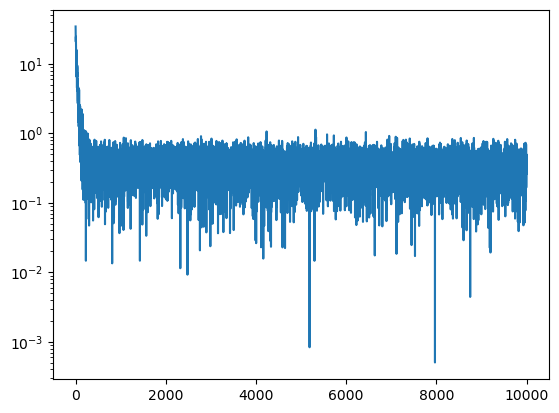

In [35]:
mlp = MLP(30, 200).requires_grad_()

limit = 200

losses, val_losses = train(mlp, 10_000, lr=lambda _step, _n_step: 0.1, X=X[:limit], y=y[:limit])

plt.plot(*zip(*losses))

plt.yscale('log')

F.cross_entropy(mlp(X[:limit]), y[:limit]).item(), F.cross_entropy(mlp(X_val), y_val).item()

Look at the underlying data

In [36]:
training_data = ''.join([i2s[a] for a in y[:limit]]).split('.')
for d in training_data:
    print(d)

splunk
thenwa
soylent
factorio
christinaricci
blues
vegancheesemaking
goldredditsays
reformed
nagoya
accidentalcosplay
tearsofthekingdom
jameswebb
blazblue
emilyatack
infjmemes
sarahstephens
bengalila


Random samples are almost entirely from that data

In [37]:
def sample(mlp, pad_idx=PAD_IDX, block_size=block_size, i2s=i2s, generator=None):
    ans = []
    state = torch.tensor([[pad_idx] * block_size])
    while True:
        probs = mlp(state).softmax(axis=1)
        next_idx = torch.multinomial(mlp(state).softmax(axis=1), 1, generator=generator)
        state = torch.concat([state, next_idx], axis=1)[:,1:]
        
        next_idx = next_idx[0,0].item()
        if next_idx == pad_idx:
            return ''.join(ans)
        ans.append(i2s[next_idx])

g = torch.Generator().manual_seed(241738025913704212)
samples = [sample(mlp, generator=g) for _ in range(20)]
for s in sorted(samples):
    print(s)

accident
accident
accidentalcosplay
bengalilaro9y8_5g6
bengalilaro9yrjecdc
bengalilaro9yrjecdclwenin4ozyylentalcosplunk
bengalilaro9yrjecdcqt1e4e1
bengalilaroljsemakingdom
blues
blues
christinaricci
christinaricci
christinariccident
factorio
james
james
sarahstephens
splay
tearsoftheking
thens


In fact most of the quadruplets are from the training data, as you would expect in an overfit model.

In [38]:
chars = []
for d in training_data:
    padded_tokens = '.' * block_size + d + '.'
    chars += list(map(''.join, zip(*[padded_tokens[i:] for i in range(block_size+1)])))
    
sample_chars = []
for d in samples:
    padded_tokens = '.' * block_size + d + '.'
    sample_chars += list(map(''.join, zip(*[padded_tokens[i:] for i in range(block_size+1)])))
                  
f'{sum(s in chars for s in sample_chars) / len(sample_chars):0.2%}'

'76.61%'

Let's now train a small model; unlike Bengio we don't need to worry about parallelism - it runs fast enough on a CPU.

This small MLP is competitive with the bigram model that got a loss of 2.73.

  0%|          | 0/100000 [00:00<?, ?it/s]

2.7286570072174072

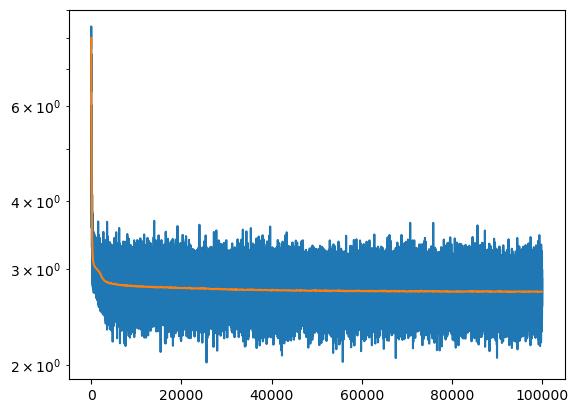

In [39]:
mlp = MLP(2, 10).requires_grad_()

losses, val_losses = train(mlp, 100_000, lambda _step, _n_step: 0.1)

plt.plot(*zip(*losses))
plt.plot(*zip(*val_losses))

plt.yscale('log')
F.cross_entropy(mlp(X_val), y_val).item()

Note that it only has a fraction of the parameters of the bigram model

In [40]:
f'{sum([len(p) for p in mlp.parameters()]) / (V*V):0.2%} of the parameters of the bigram model'

'7.06% of the parameters of the bigram model'

Because we chose a 2 dimensional embedding we can plot the characters.

There are some features that make sense:

* The vowels are in a cluster together
* The numbers form clusters

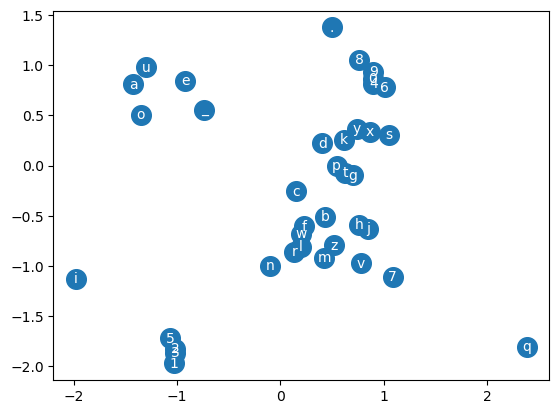

In [41]:
emb = mlp.C.detach()

fig, ax = plt.subplots()
ax.scatter(*zip(*emb), s=200)

for i, txt in enumerate(i2s):
    ax.annotate(txt, emb[i], horizontalalignment='center', verticalalignment='center', color='white')

We can sample from this model; it's a little English-y but mostly noise.

In [42]:
g = torch.Generator().manual_seed(241738025913704212)
for _ in range(20):
    print(sample(mlp, generator=g))

aulaxbunale
nomawkby
chirlarhanosedescus
icles
ylorfruth
gakicsty
tinarcicy
xhamgecrusklabkios
nantyel
rodcox
spare
perwarapu
actesamil
8agan
akinzimedht
artnindams
bolp
p_na_wfizeycorfedpeplyirgarkmeyekbelipamubitwera
btspchupcilra
raramis


We could also scale up to a larger model.

We can increase the learning rate exponentially to find a good learning rate.
Here 0.1 is reasonable because we want somewhere before the loss starts to diverge.

  0%|          | 0/1000 [00:00<?, ?it/s]

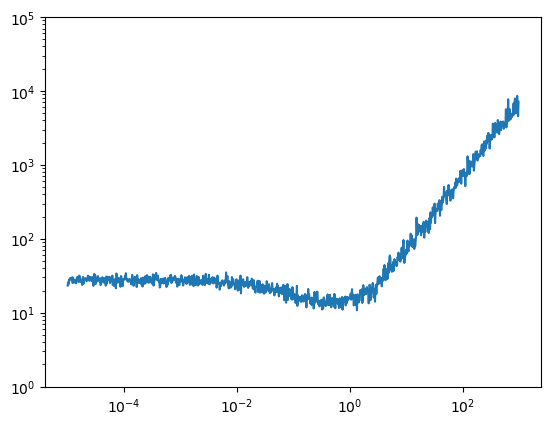

In [43]:
def lr_finder(step, N_step):
    return 10**(-5+ 8*step/N_step)

mlp = MLP(30, 200).requires_grad_()

losses, val_losses = train(mlp, 1000, lr_finder) 

plt.plot([lr_finder(l[0], 1000) for l in losses], [l[1] for l in losses])
plt.ylim((1, 10**5))
plt.yscale('log')
plt.xscale('log')

We can then train it and get an even better result.

  0%|          | 0/100000 [00:00<?, ?it/s]

2.568157196044922

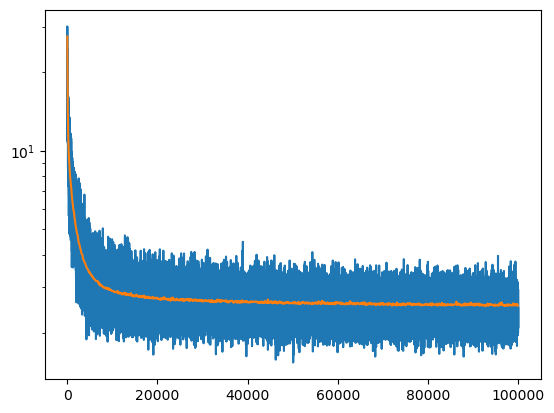

In [44]:
mlp = MLP(30, 200).requires_grad_()

losses, val_losses = train(mlp, 100_000, lambda _step, _n_step: 0.1)

plt.plot(*zip(*losses))
plt.plot(*zip(*val_losses))

plt.yscale('log')
F.cross_entropy(mlp(X_val), y_val).item()

The results are still not great but there are little pieces of real words in some of them.

In [45]:
g = torch.Generator().manual_seed(241738025913704212)
for _ in range(20):
    print(sample(mlp, generator=g))

ancanburgee
nimag
bybost
carencosleencus
inles
natsfrush
gatics
yatinarching
games
ruskncheroa
nahenews
fucofba
fates
awthaposactionmistragan
akingifwatt
artugn
ami
battor_namainternerfaipermains
famentibelgpamatiowar
antspching


# What next?

This showed that even these small tri-gram MLPs can beat the bigram model.
However the bigram model was easy to optimise (by counting!) wheras these models are a lot trickier.
I don't know whether the models trained here are close to the global optimum, and I would like to understand this in more detail.